In [1]:
import os
os.environ['R_HOME'] = '/home/ec2-user/anaconda3/envs/R/lib/R'
os.environ["NUMEXPR_MAX_THREADS"] = '36'

In [5]:
import pandas as pd
import numpy as np
import joblib

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

%run procedural_stop_words.py
procedural_stop_words.extend(['do','be','mr_speaker','have','time','other'])

from tqdm import tqdm
from plotnine import ggplot, aes, geoms, annotate, ylim, facet_wrap, theme, element_blank,element_text,element_line,element_rect, ggtitle

# R package import 
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

R = ro.r
pandas2ri.activate()

from statsmodels.stats.multitest import fdrcorrection
import time

from multiprocess import Pool
import logging

logging.basicConfig(filename='Results/Frame_log.log', level=logging.DEBUG)

In [6]:
all_df = pd.read_csv('Results/All_speeches_labelled.csv')

### Check for imbalanced in number of speakers for each topic over time

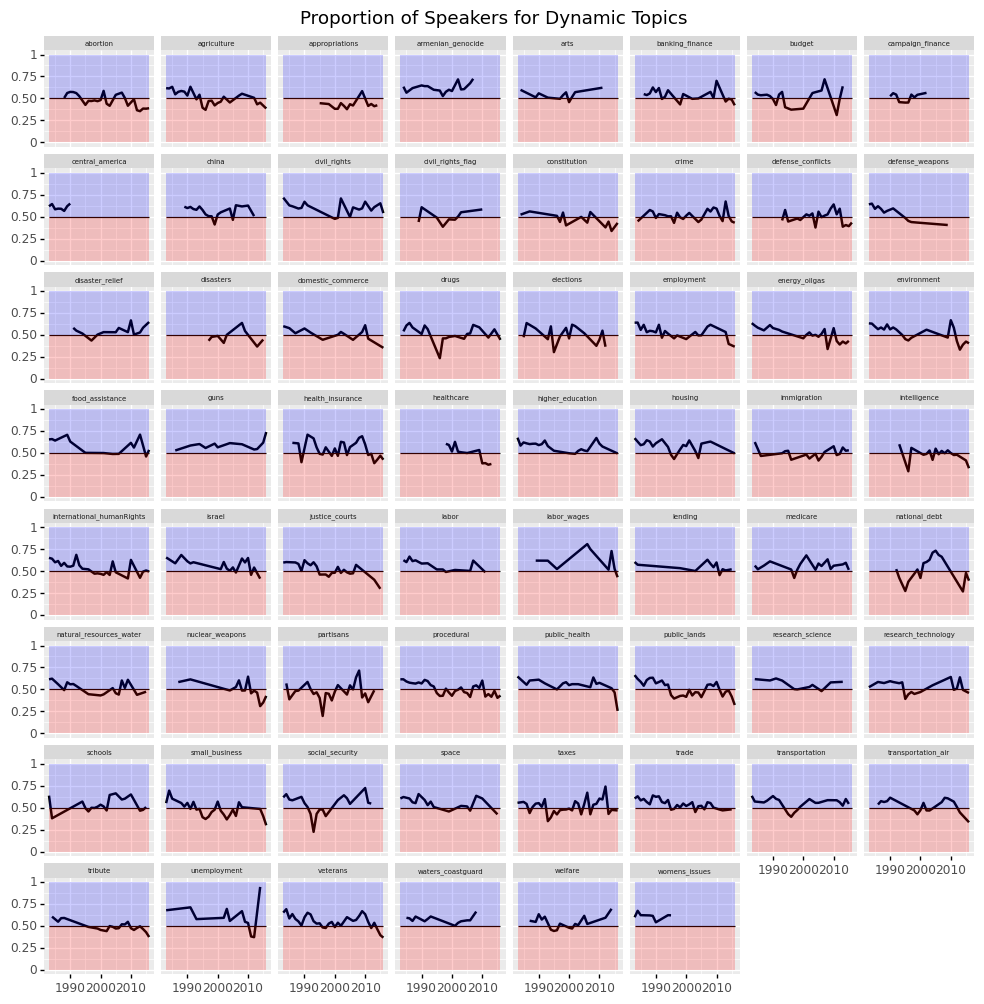

<ggplot: (8766121585692)>

In [122]:
count_df = (all_df.
            groupby(['dynamic_label','year_y','speaker'],as_index=False)
            .party_y.first()
            .groupby(['dynamic_label','year_y','party_y'],as_index=False)
            .count()
           )

count_df['year_total'] = count_df.groupby(['dynamic_label','year_y']).speaker.transform('sum')

count_df =( count_df
            .loc[count_df.party_y == 'D']
            .pipe(lambda x: x.assign(proportion = x.speaker/x.year_total))
          )

(
    ggplot(count_df,aes(x = 'year_y',y='proportion')) + 
    geoms.geom_line(size=1) + 
    annotate('segment',x=count_df.year_y.min(),xend=count_df.year_y.max(),y=.50,yend=.50) +
    annotate("rect", xmin=count_df.year_y.min(),xmax=count_df.year_y.max(),ymin=.5,ymax=1,alpha=0.2,fill='blue') +
    annotate("rect", xmin=count_df.year_y.min(),xmax=count_df.year_y.max(),ymin=.5,ymax=0,alpha=0.2,fill='red') +
    ylim(0,1) + 
    theme(axis_title=element_blank(),
          figure_size=(12,12),
          strip_text=element_text(size=5)) +
    facet_wrap('~dynamic_label') + 
    ggtitle("Proportion of Speakers for Dynamic Topics")
)


## For Speakers

A massive-univariate technique in which every phrases is tested against the null-hypothesis that the frequency distribution of the word for Democrats and Republicans come from the same underlying distribution. This analysis is akin to the mass-univeraite analysis undertaken in basic neuroimaging research, where each voxel is analyzed independently given the same model. Results are of course corrected for multiple comparison using FDR correction.



In [7]:
def run_poisson(info):
    """
    Runs Poisson regression for terms
    """
    col,DTM = info
    
    mod = R.glm(f'x_{col} ~ x_weighted_party + x_speakerFreq',family='poisson',data=DTM)
    
    effects = R.summary(mod).rx2('coefficients')
    
    return {'col':col,
            'party_est':effects[1,0],'party_pval':effects[1,-1],
            'speaker_est':effects[2,0],'speaker_pval':effects[2,-1]}


def run_model(year,topic,binary=True,min_df=0.05,num_cpu=30):
    
    # subset dataframe for year and topic
    sub_df = all_df.loc[(all_df.year_y == year) & (all_df.dynamic_label == topic)]
    
    if len(sub_df) > 0:
        
        # set up model feature matrix
        features = sub_df.groupby('speaker',as_index=False).agg({"party_x":'count','party_y':'first'})
        features.columns = ['speaker','speakerFreq','party']

        # weighted party class
        features['weighted_party'] = [0 if _ == 'D' 
                                      else len(features)/(2*features.party.value_counts()['R']) 
                                      for _ in features.party]

        
        # term DTM
        vectorizer = CountVectorizer(stop_words=procedural_stop_words,min_df=min_df,binary=binary)
        DTM = vectorizer.fit_transform(sub_df.speech_processed)
        DTM = pd.DataFrame(DTM.toarray())
        
        terms = vectorizer.get_feature_names() # vocabulary
        
        # sum term occurance by speaker and merge with party
        DTM['speaker'] = list(sub_df['speaker'])
        DTM = (DTM
               .groupby('speaker',as_index=False)
               .sum()
               .merge(features,on='speaker',how='left')
               .drop('speaker',1)
              )
        
        # give columns names compatible with R
        DTM.columns = [f'x_{i}' for i in DTM.columns]
        
        # Run Massive Univariate Poisson GLM
        iter_list = [(i,DTM) for i in range(len(terms))]
        
        with Pool(num_cpu) as p:
            estimates = p.map(run_poisson,iter_list)
        
        # Make to DataFrame
        frame = pd.DataFrame(estimates)
        frame['term'] = terms
        frame['year'] = year
        frame['topic'] = topic
        frame = frame.drop('col',1)
        
        # perform FDR correction for multiple comparisons, alpha = 0.05
        frame['fdr_p'] = fdrcorrection(frame.party_pval)[0]
        
        return frame

In [ ]:
logging.debug('   Starting Models')
Frames = []
for topic in all_df.dynamic_label.unique(): # for each topic
    start_time = time.time()
    for year in range(1983,2017): # for every year
        Frames.append(run_model(year,topic))    
    
    end_time = time.time()
    logging.debug(f'  topic - {topic} completed in {(end_time-start_time)/60} minutes.')
    
All_terms = pd.concat(Frames)
All_terms.to_csv('Results/Weighted_Univariate_Frame_analysis.csv')

In [ ]:
logging.debug('   Starting Models')
Frames = []
for topic in all_df.dynamic_label.unique(): # for each topic
    start_time = time.time()
    for year in range(1983,2017): # for every year
        Frames.append(run_model(year,topic,binary=False))    
    
    end_time = time.time()
    logging.debug(f'  topic - {topic} completed in {(end_time-start_time)/60} minutes.')
    
All_terms = pd.concat(Frames)
All_terms.to_csv('Results/Weighted__nonbinary_Univariate_Frame_analysis.csv')